## 淘宝用户行为分析

### 一、项目背景  

通过天池提供的淘宝app平台数据集，通过行业的指标对淘宝用户行为进行分析，探索淘宝用户行为模式。  

数据来源: https://tianchi.aliyun.com/dataset/dataDetail?dataId=46&userId=1

### 二、内容探索  

1. 日PV有多少?  
2. 日UV有多少?  
3. 付费率情况如何?  
4. 复购率表现怎样?  
5. 漏斗流失情况如何?  
6. 用户价值情况?

### 三、数据导入  

数据集有104万条左右数据，统计年份为2014年11月18日至2014年12月18日，数据均已脱敏。

__字段描述:__  

user_id: 用户ID  
item_id: 商品ID  
behavior_type: 用户行为类型(点击、收藏，加购，支付,分别用数字1、2、3、4表示)  
user_geohash: 地理位置  
item_category: 商品的类别ID  
time: 行为时间  

In [1]:
# 导入必要模块
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# 解决可视化中的中文显示问题
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['STSong']
plt.rcParams['axes.unicode_minus'] = False  # 负号显示

In [3]:
path = 'D:/shujufenxi/xls_shuju/淘宝App用户使用行为数据集/'

In [4]:
data = pd.read_csv(path + 'tianchi_mobile_recommend_train_user.csv')
data.head()

,user_id,item_id,behavior_type,user_geohash,item_category,time
0,98047837,232431562,1,NaN,4245,2014-12-06 02
1,97726136,383583590,1,NaN,5894,2014-12-09 20
2,98607707,64749712,1,NaN,2883,2014-12-18 11
3,98662432,320593836,1,96nn52n,6562,2014-12-06 10
4,98145908,290208520,1,NaN,13926,2014-12-16 21


In [5]:
# 查看数据类型
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12256906 entries, 0 to 12256905
Data columns (total 6 columns):
user_id          int64
item_id          int64
behavior_type    int64
user_geohash     object
item_category    int64
time             object
dtypes: int64(4), object(2)
memory usage: 561.1+ MB


In [6]:
# 缺失值处理
data.isnull().sum()

user_id                0
item_id                0
behavior_type          0
user_geohash     8334824
item_category          0
time                   0
dtype: int64

虽然user_geohash存在缺失值，但通过经验判断，App会将地理信息做加密处理，所以不能删除缺失值，暂不对数据集做处理

In [7]:
# 时间字段处理
data['date'] = data['time'].apply(lambda x: x.split(' ')[0])
data['hour'] = data['time'].apply(lambda x: x.split(' ')[1])
data.head()

,user_id,item_id,behavior_type,user_geohash,item_category,time,date,hour
0,98047837,232431562,1,NaN,4245,2014-12-06 02,2014-12-06,02
1,97726136,383583590,1,NaN,5894,2014-12-09 20,2014-12-09,20
2,98607707,64749712,1,NaN,2883,2014-12-18 11,2014-12-18,11
3,98662432,320593836,1,96nn52n,6562,2014-12-06 10,2014-12-06,10
4,98145908,290208520,1,NaN,13926,2014-12-16 21,2014-12-16,21


In [8]:
data['time'] = pd.to_datetime(data['time'])
data['date'] = pd.to_datetime(data['date'])
data['hour'] = data['hour'].astype('int64')

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12256906 entries, 0 to 12256905
Data columns (total 8 columns):
user_id          int64
item_id          int64
behavior_type    int64
user_geohash     object
item_category    int64
time             datetime64[ns]
date             datetime64[ns]
hour             int64
dtypes: datetime64[ns](2), int64(5), object(1)
memory usage: 748.1+ MB


In [10]:
# 异常值处理
data.describe()

,user_id,item_id,behavior_type,item_category,hour
count,1.225691e+07,1.225691e+07,1.225691e+07,1.225691e+07,1.225691e+07
mean,7.170732e+07,2.023084e+08,1.105271e+00,6.846162e+03,1.481799e+01
std,4.122920e+07,1.167397e+08,4.572662e-01,3.809922e+03,6.474778e+00
min,4.913000e+03,6.400000e+01,1.000000e+00,2.000000e+00,0.000000e+00
25%,3.584965e+07,1.014130e+08,1.000000e+00,3.721000e+03,1.000000e+01
50%,7.292804e+07,2.021359e+08,1.000000e+00,6.209000e+03,1.600000e+01
75%,1.073774e+08,3.035405e+08,1.000000e+00,1.029000e+04,2.000000e+01
max,1.424559e+08,4.045625e+08,4.000000e+00,1.408000e+04,2.300000e+01


观察数据集的总体描述没有异常值存在

### 四、用户行为分析

#### 1. PV和UV分析

In [11]:
# PV（访问量/Page View）: 指页面的浏览量或者点击量，页面没刷新一次就计算一次
pv_daily = data.groupby('date')['user_id'].count().reset_index().rename(columns={'user_id':'pv'})

In [12]:
# UV(独立访客/Unique Vistior): 访问网站的一台电脑客户端为一个访客
uv_daily = data.groupby('date')['user_id'].apply(lambda x: x.drop_duplicates().count()).reset_index().rename(columns={'user_id':'uv'})

In [13]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

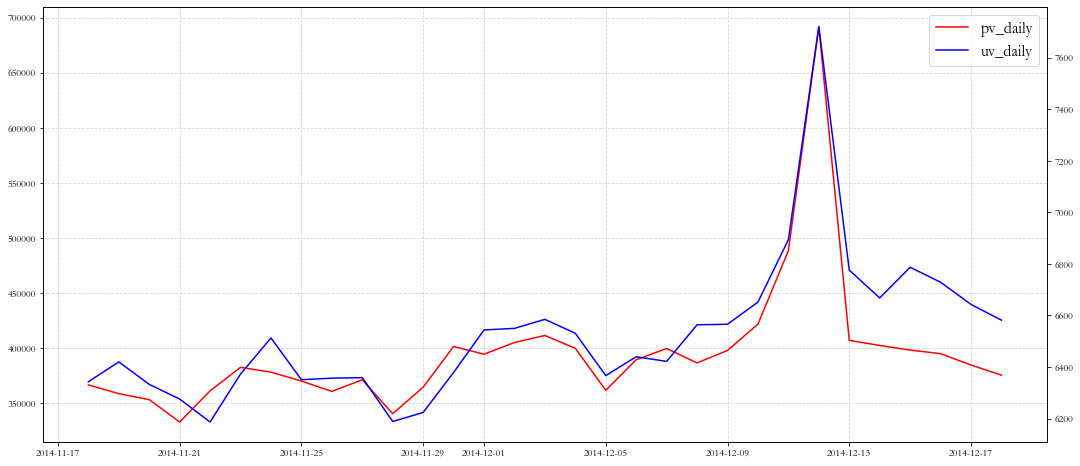

In [14]:
fig = plt.figure(figsize=(18,8))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(pv_daily['date'], pv_daily['pv'], color='red', label='pv_daily')
ax1.grid(True, linestyle="--", alpha=0.5)
ax2 = ax1.twinx()
ax2.plot(uv_daily['date'], uv_daily['uv'], color='blue', label='uv_daily')
# 图例显示
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
plt.legend(handles1+handles2, labels1+labels2, loc='best', fontsize=16)
plt.show()

如今电商节日增多，像"6·18","双11","双12"都是促进用户消费的日期，可见在截取的30天的数据里，双12期间，PV和UV访问量达到峰值，而且，PV与UV的差值较大，但趋势一致，可以认为人均日访问量不变。通过UV可以分析出，数据集中的总人数大约8000人，双十二期间淘宝app用户的日活跃有45%左右的浮动。

In [15]:
# 按小时量分析 PV和UV
pv_hour = data.groupby('hour')['user_id'].count().reset_index().rename(columns={'user_id':'pv'})
uv_hour = data.groupby('hour')['user_id'].apply(lambda x: x.drop_duplicates().count()).reset_index().rename(columns={'user_id':'uv'})

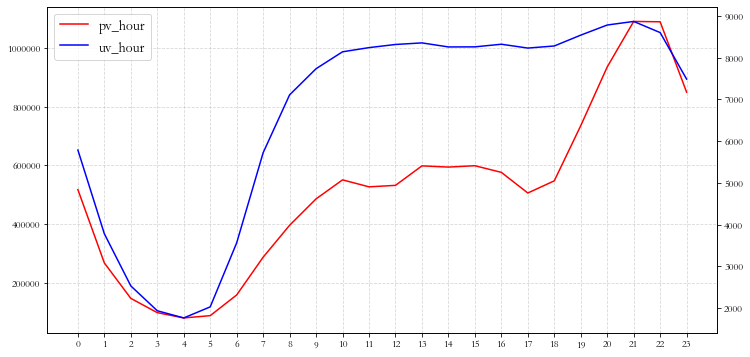

In [16]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(pv_hour['hour'], pv_hour['pv'], color='red', label='pv_hour')
ax1.set_xticks(np.arange(0,24,1))
ax1.grid(True, linestyle="--", alpha=0.5)

ax2 = ax1.twinx()
ax2.plot(uv_hour['hour'], uv_hour['uv'], color='blue', label='uv_hour')

# 图例显示
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
plt.legend(handles1+handles2, labels1+labels2, loc='best', fontsize=14)
plt.show()

在夜里21点-次日5点间，PV和UV波动一致，成下降趋势，访问量从峰值下降到谷底，这和生活作息相关，但在白天，UV值在早上8点就达到峰值，PV处于正常水平，在18点开始处于上升状态，至21点到达峰值，说明，晚上18点以后是淘宝用户的访问app的活跃时间段，与正常的作息时间一致。

In [17]:
# 分析 各用户行为类型的 PV和UV
pv_detail = data.groupby(['behavior_type', 'date'])['user_id'].count().reset_index().rename(columns={'user_id':'total_pv'})

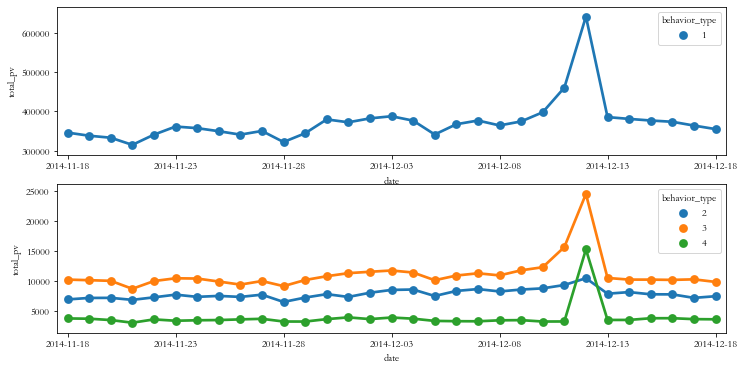

In [18]:
# 用户行为类型(点击、收藏，加购，支付,分别用数字1、2、3、4表示)
# 点击行为往往比其他行为更多，单独画图
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(2,1,1)
sns.pointplot(x='date', y='total_pv', hue='behavior_type', data=pv_detail[pv_detail.behavior_type == 1], ax=ax1)

x_tick = list(range(0,len(pv_detail.date.unique()),5))
x_label = [pv_detail.date[i].strftime('%Y-%m-%d') for i in x_tick]
ax1.set_xticks(x_tick)
ax1.set_xticklabels(x_label,rotation=0)

ax2 = fig.add_subplot(2,1,2)
sns.pointplot(x='date', y='total_pv', hue='behavior_type', data=pv_detail[pv_detail.behavior_type != 1], ax=ax2)

ax2.set_xticks(x_tick)
ax2.set_xticklabels(x_label,rotation=0)
plt.show()

在这张图中，尽管在双12期间，点击、收藏、加购的用户行为增多，但收藏行为还是和往常一样。这可能因为，双12活动促销，商品品类增多，致使用户查看商品的行为增多，也会产生大量的购买欲望，不再将商品收藏，直接买买买。

In [19]:
pv_detail_hour = data.groupby(['behavior_type', 'hour'])['user_id'].count().reset_index().rename(columns={'user_id':'total_pv_hour'})

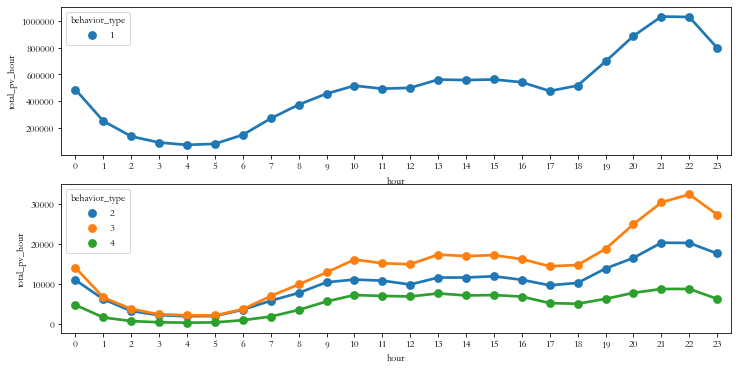

In [20]:
# 用户行为类型(点击、收藏，加购，支付,分别用数字1、2、3、4表示)
# 点击行为往往比其他行为更多，单独画图
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(2,1,1)
sns.pointplot(x='hour', y='total_pv_hour', hue='behavior_type', data=pv_detail_hour[pv_detail_hour.behavior_type == 1], ax=ax1)

ax2 = fig.add_subplot(2,1,2)
sns.pointplot(x='hour', y='total_pv_hour', hue='behavior_type', data=pv_detail_hour[pv_detail_hour.behavior_type != 1], ax=ax2)
plt.show()

可以看到点击行为相较于其他用户行为，pv访问量较高，而且支付量是较低的，符合用户行为漏斗流失模型，收藏量对比加购行为较低，主要原因App的加购按钮比收藏更为显眼，而且购物车有个单独的显示页面，用户可以更方便的了解购物车页面商品的信息，四种行为在整体趋势上有一致性，在晚上，无论暗中用户行为，pv访问量都是最高的。

#### 2. 用户消费行为分析

In [21]:
# 1). 用户购买次数情况分析
user_buy = data[data.behavior_type==4].groupby('user_id')['behavior_type'].count()

用户购买次数中位数:  8.0


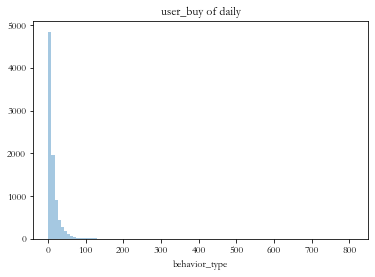

In [22]:
sns.distplot(user_buy, bins=100, kde=False)
plt.title('user_buy of daily')
print('用户购买次数中位数: ',user_buy.median())
plt.show()

淘宝App用户每月消费次数普遍在10次以内，因此本次分析重点关注次数在10次以上的消费者用户群体，为什么会产生高频次购买行为。

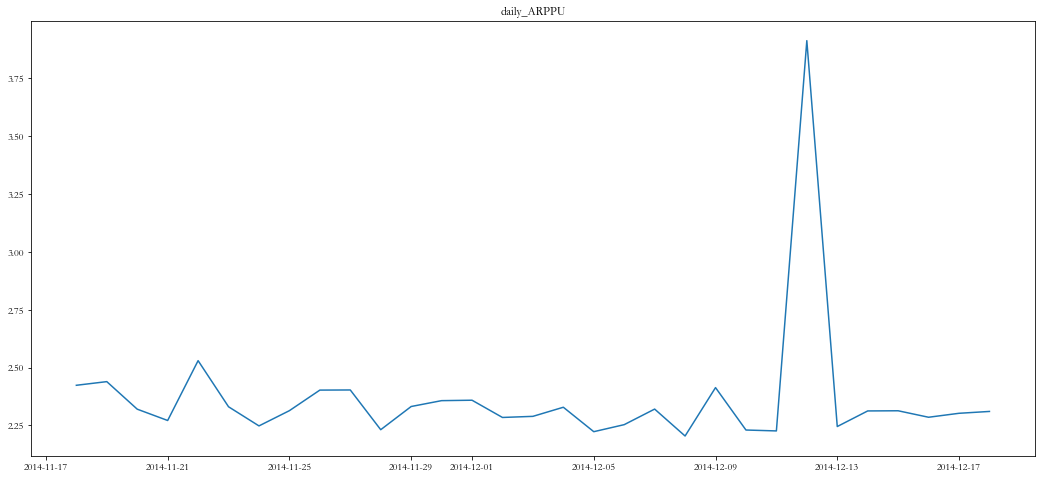

In [23]:
# 日ARPPU （指从每位付费用户身上获得的收入，反映的是每个付费用户的平均付费额度）
# ARPPU = 总收入/活跃用户付费数量
# 付费人均消费次数 = 消费总次数/付费总人数
daily_ARPPU = data[data.behavior_type==4].groupby(['date','user_id'])['behavior_type'].count().reset_index().rename(columns={'behavior_type':'total'})
daily_ARPPU = daily_ARPPU.groupby('date').apply(lambda x: x.total.sum()/x.total.count())

plt.figure(figsize=(18,8))
plt.plot(daily_ARPPU)
plt.title('daily_ARPPU')
plt.show()

在这30天的数据中，付费用户平均购买次数大约为2次，双十二达到人均购买4次。

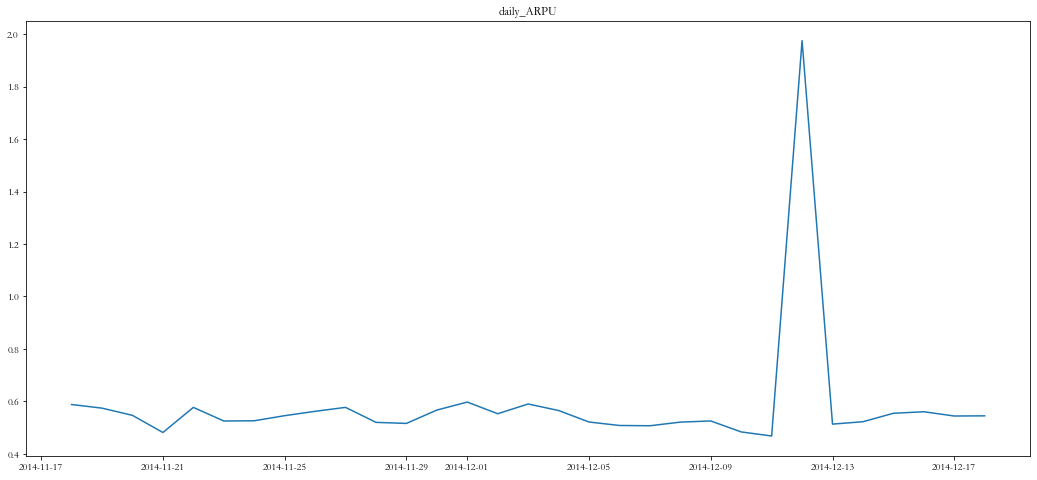

In [24]:
# 日ARPU：平均每用户收入，可通过总收入/总人数计算得出，用来衡量盈利能力和发展活力
# 活跃用户数平均消费次数=消费总次数/活跃用户人数
data['operation'] = 1  # 设定操作值，便于计数
daily_ARPU = data.groupby(['date','user_id','behavior_type'])['operation'].count().reset_index().rename(columns={'operation':'total'})
daily_ARPU = daily_ARPU.groupby('date').apply(lambda x:x[x.behavior_type==4].total.sum()/len(x.user_id.unique()))

plt.figure(figsize=(18,8))
plt.plot(daily_ARPU)
plt.title('daily_ARPU')
plt.show()

双十二促销活动中，人均消费次数达2次

用户消费次数众数:  1


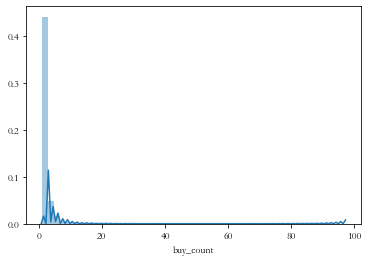

In [25]:
# 同时间段用户消费次数分布
user_count_of_buy = data[data.behavior_type==4].groupby(['user_id','date','hour'])['operation'].sum().rename('buy_count')

plt.figure()
sns.distplot(user_count_of_buy)
print('用户消费次数众数: ', user_count_of_buy.mode()[0])

#### 3.复购情况分析

- 复购行为: 两天以上有购买行为，一天内购买多次算一次  
- 复购率: 有复购行为的用户数 / 购买用户总人数

In [26]:
date_rebuy = data[data['behavior_type']==4].groupby('user_id')['date'].apply(lambda x:len(x.unique()))

print('复购率: ', round(date_rebuy[date_rebuy>=2].count()/date_rebuy.count(),4))

复购率:  0.8717


In [27]:
# 所有复购时间间隔消费次数分布
date_buy_day = data[data.behavior_type==4].groupby(['user_id','date']).operation.count().reset_index()
date_buy_day = date_buy_day.groupby('user_id')['date'].apply(lambda x:x.sort_values().diff(1).dropna()).reset_index()
date_buy_day = date_buy_day['date'].apply(lambda x:x.days)

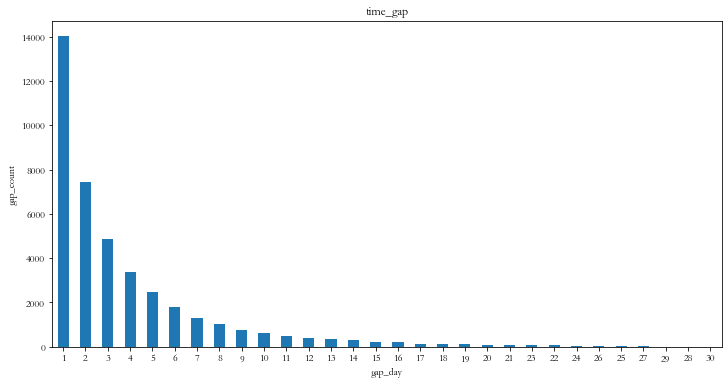

In [28]:
plt.figure(figsize=(12,6))
date_buy_day.value_counts().plot(kind='bar')
plt.xticks(rotation=0)
plt.title('time_gap')
plt.xlabel('gap_day')
plt.ylabel('gap_count')
plt.show()

In [29]:
print('多数人复购率: ',round(date_rebuy[date_rebuy>=2].value_counts().head(3).sum()/date_rebuy.count(),2))

多数人复购率:  0.36


多数用户复购率为0.36，消费次数随着消费时间间隔的增加而不断下降，间隔天数达10天后，淘宝App用户很少进行复购行为，需要加强对淘宝复购用户10天之内行为监测，以提高淘宝App的复购率。

#### 4.漏斗流失分析

漏斗分析可以科学反映用户行为状态，从流程起点到终点的转化率情况的重要分析模型，是一个流程式数据分析。

In [30]:
user_count = data.groupby('behavior_type').count()
user_count

,user_id,item_id,user_geohash,item_category,time,date,hour,operation
behavior_type,,,,,,,,
1,11550581,11550581,3704666,11550581,11550581,11550581,11550581,11550581
2,242556,242556,74365,242556,242556,242556,242556,242556
3,343564,343564,104443,343564,343564,343564,343564,343564
4,120205,120205,38608,120205,120205,120205,120205,120205


In [31]:
# 不同用户行为类别的转化率
conversion_rate = data[data.behavior_type!=2].groupby('behavior_type')['operation'].count()

In [32]:
# 漏斗图展示
from pyecharts.charts import Funnel
from pyecharts import options as opts

In [33]:
funnel = (Funnel()
         .add('用户数',[list(z) for z in zip(['点击量','加入购物车','购买量'],conversion_rate.values.tolist())],
             label_opts=opts.LabelOpts(position='inside'))
         .set_global_opts(title_opts=opts.TitleOpts(title='淘宝App用户行为漏斗图'))
         )
funnel.render('淘宝App用户行为漏斗图.html')
funnel.render_notebook()

In [34]:
# 用户行为与商品品类的转换率
cate_rate = data[data.behavior_type!=2].groupby(['item_category','behavior_type'])['operation'].count().unstack().rename(columns={1:'点击量', 3:'加入购物车', 4:'购买量'}).fillna(0)

In [35]:
cate_rate.sort_values(by=['点击量','购买量'],ascending=False).head(15)

behavior_type,点击量,加入购物车,购买量
item_category,,,
1863,371738.0,9309.0,2000.0
13230,342694.0,6012.0,841.0
5027,320870.0,5564.0,858.0
5894,314784.0,6615.0,958.0
6513,281370.0,6651.0,1059.0
5399,268639.0,5430.0,1054.0
11279,177961.0,3686.0,722.0
2825,155949.0,3692.0,625.0
5232,135506.0,4486.0,1611.0


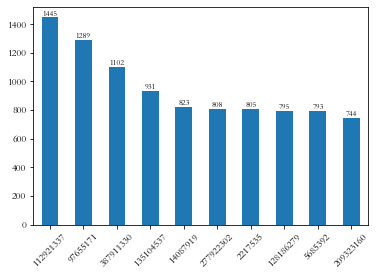

In [36]:
## 用户最常购买的商品
item_user = data.item_id.value_counts().head(10)
item_user.plot(kind='bar')
number = item_user.values.tolist()
for x,y in zip(range(10),number):
    plt.text( x, y, y, ha='center', va='bottom', fontsize=8)
plt.xticks(rotation=45)
plt.show()

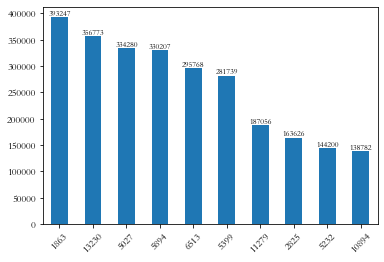

In [37]:
# 用户最常购买的商品品类
cate_user = data.item_category.value_counts().head(10)
cate_user.plot(kind='bar')
number = cate_user.values.tolist()
for x,y in zip(range(10),number):
    plt.text(x, y, y, ha='center', va='bottom', fontsize=8)
plt.xticks(rotation=45)
plt.show()

### 五、用户价值分层（RFM模型）

由于数据集中没有消费金额(M)，所以暂且通过最近一次购买时间(R)和消费频率(F)的数据对客户的价值进行分层。  
将最后购买时间定为假定统计时间2014年12月20日

In [38]:
from datetime import datetime

In [39]:
base = datetime(2014,12,20)
recent_buy = data[data['behavior_type']==4].groupby('user_id')['date'].apply(lambda x: (base-x.sort_values()).iloc[-1].days)
recent_buy = recent_buy.reset_index().rename(columns={'date':'recent'})
recent_buy.head()

,user_id,recent
0,4913,4
1,6118,3
2,7528,7
3,7591,7
4,12645,6


In [40]:
freq_buy = data[data['behavior_type']==4].groupby('user_id')['date'].count()
freq_buy = freq_buy.reset_index().rename(columns={'date':'freq'})
freq_buy.head()

,user_id,freq
0,4913,6
1,6118,1
2,7528,6
3,7591,21
4,12645,8


In [41]:
RFM = recent_buy.merge(freq_buy, how='inner', on='user_id')
RFM.head()

,user_id,recent,freq
0,4913,4,6
1,6118,3,1
2,7528,7,6
3,7591,7,21
4,12645,6,8


In [42]:
# RFM 各个业务分组要求不一样，这里暂且以桶分法分组
RFM['recent_value'] = pd.qcut(RFM.recent, 2, labels=['1','0'])
RFM['freq_value'] = pd.qcut(RFM.freq, 2, labels=['0','1'])
RFM.head()

,user_id,recent,freq,recent_value,freq_value
0,4913,4,6,1,0
1,6118,3,1,1,0
2,7528,7,6,0,0
3,7591,7,21,0,1
4,12645,6,8,1,0


In [43]:
RFM['RFM'] = RFM['recent_value'].str.cat(RFM['freq_value'])
RFM.head()

,user_id,recent,freq,recent_value,freq_value,RFM
0,4913,4,6,1,0,10
1,6118,3,1,1,0,10
2,7528,7,6,0,0,00
3,7591,7,21,0,1,01
4,12645,6,8,1,0,10


In [44]:
# 划分用户等级
def level_RFM(x):
    if x == '11':
        return '重要价值客户'
    elif x == '10':
        return '重要发展客户'
    elif x == '01':
        return '重要保持客户'
    elif x == '00':
        return '一般价值客户'
RFM['用户等级'] = RFM['RFM'].apply(level_RFM)

In [45]:
RFM.head()

,user_id,recent,freq,recent_value,freq_value,RFM,用户等级
0,4913,4,6,1,0,10,重要发展客户
1,6118,3,1,1,0,10,重要发展客户
2,7528,7,6,0,0,00,一般价值客户
3,7591,7,21,0,1,01,重要保持客户
4,12645,6,8,1,0,10,重要发展客户


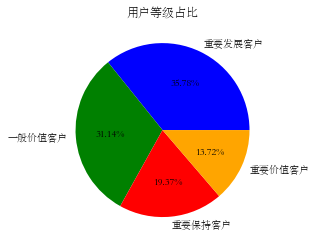

In [46]:
# 用户等级占比
plt.figure(figsize=(4,4))
plt.pie(RFM['用户等级'].value_counts(), labels=RFM['用户等级'].unique(), autopct='%1.2f%%', colors=('blue', 'green', 'red', 'orange'))
plt.title('用户等级占比')
plt.show()

对于重要价值用户，他们是最优质的用户，需要重点关注并保持， 应该提高满意度，增加留存；

对于重要保持用户，他们最近有购买，但购买频率不高，可以通过活动等提高其购买频率；

对于重要发展用户，他们虽然最近没有购买，但以往购买频率高，可以做触达，以防止流失；

对于一般价值用户，他们最近没有购买，以往购买频率也不高，特别容易流失，所以应该赠送优惠券或推送活动信息，唤醒购买意愿。

### 总结

__结论:__
1. 用户在一天内消费最高的时间段是晚上18点到23点，其中21点达到峰值;  
2. 在双十二促销日里，用户消费水平比其他日期要高;  
3. 用户点击率较高的商品支付量要高;
4. 加入购物车的商品有较大的几率转换为已支付商品;  
5. 用户最常购买的商品为11292137，商品品类为1863;  
6. 一般价值用户和重要保持用户占比较高。  

__建议:__  
1. 增加客服在晚间的工作时间，引导用户成功购买商品;  
2. 优化电商平台的搜索匹配度和推荐策略。增加用户点击率;  
2. 适当增加双十二的活动时长，让用户有足够的时间浏览新上架的商品，增加点击量;  
3. 可以考虑增加用户最常购买的商品品类的库存量;  
4. 根据RFM模型，找到最具价值的核心付费用户群，对其进行重点关注;  
5. 对于重要价值用户，可以针对该用户开展相应的运营活动，提高用户产品使用频率。